<a href="https://colab.research.google.com/github/TRD159/COSC-4368/blob/main/CNN_Assignment2_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Design Challenge - Tiny ImageNet Classification

**Dataset:**
- 15 classes
- 64×64 RGB images
- Training: 5,775 images
- Validation: 825 images

Dataset Details

*   Dataset name: Tiny ImageNet (Subset)
*   Number of classes: 15
* Image size: 64 × 64 pixels (RGB)
* Total images: 8250
* Provided data split:
  Training: 70% (5775), Validation: 10% (825), Hidden test: 20% (1650)

## 1. Setup Environment

In [ ]:
# Install required packages (if needed)
!pip install -q torch torchvision numpy matplotlib scikit-learn tqdm Pillow

# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ WARNING: GPU not available. Training will be slow!")
    print("Enable GPU: Runtime > Change runtime type > GPU")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [ ]:
# Import libraries
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import random
from PIL import Image

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("✓ All imports successful!")

✓ All imports successful!


## 2. Upload Data Files

**Option 1: Upload directly (for smaller files)**
- Click the folder icon on the left
- Upload `train-70_.pkl` and `validation-10_.pkl`

**Option 2: From Google Drive (recommended for large files)**
- Run the cell below to mount Google Drive
- Upload files to Drive first, then access them

In [ ]:
# Optional: Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# If using Google Drive, update these paths:
# TRAIN_PICKLE = '/content/drive/MyDrive/train-70_.pkl'
# VAL_PICKLE = '/content/drive/MyDrive/validation-10_.pkl'

# If uploaded directly to Colab:
TRAIN_PICKLE = 'train-70_.pkl'
VAL_PICKLE = 'validation-10_.pkl'

# Check if files exist
if os.path.exists(TRAIN_PICKLE):
    print(f"✓ Found {TRAIN_PICKLE}")
else:
    print(f"❌ {TRAIN_PICKLE} not found. Please upload it.")

if os.path.exists(VAL_PICKLE):
    print(f"✓ Found {VAL_PICKLE}")
else:
    print(f"❌ {VAL_PICKLE} not found. Please upload it.")

✓ Found train-70_.pkl
✓ Found validation-10_.pkl


## 3. Dataset Class

In [ ]:
class TinyImageNetDataset(Dataset):
    """Custom Dataset for loading Tiny ImageNet from pickle files"""

    def __init__(self, pickle_file, transform=None):
        print(f"Loading data from {pickle_file}...")
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)

        # Extract images and labels
        if isinstance(data, dict):
            self.images = data.get('images', data.get('data', None))
            self.labels = data.get('labels', data.get('targets', None))
        elif isinstance(data, tuple):
            self.images, self.labels = data
        else:
            raise ValueError("Unknown pickle file structure")

        self.images = np.array(self.images)
        self.labels = np.array(self.labels)

        # Ensure images are in correct shape: (N, H, W, C)
        if self.images.ndim == 4:
            if self.images.shape[-1] == 3:
                pass  # Already in (N, H, W, C) format
            elif self.images.shape[1] == 3:
                self.images = np.transpose(self.images, (0, 2, 3, 1)) # Convert NCHW to NHWC

        # Normalize pixel values to [0, 1] if needed
        if self.images.max() > 1.0:
            self.images = self.images.astype(np.float32) / 255.0

        # Remap labels to be 0-indexed and contiguous
        unique_labels = sorted(np.unique(self.labels))
        self.label_map = {original_label: new_label for new_label, original_label in enumerate(unique_labels)}
        self.labels = np.array([self.label_map[label] for label in self.labels])

        self.transform = transform

        print(f"Loaded {len(self.images)} images with shape {self.images.shape}")
        print(f"Labels shape: {self.labels.shape}, Unique classes (remapped): {len(np.unique(self.labels))}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            if image.max() <= 1.0: # Check if normalization might have already happened
                image = (image * 255).astype(np.uint8)
            image = Image.fromarray(image)
            image = self.transform(image)
        else:
            # Convert numpy array to torch tensor and permute for PyTorch (CHW)
            image = torch.from_numpy(image).permute(2, 0, 1).float()

        return image, torch.tensor(label, dtype=torch.long)

## 4. Explore Data (Optional)

In [ ]:
# Load data for exploration
def explore_data(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)

    if isinstance(data, dict):
        images = data.get('images', data.get('data', None))
        labels = data.get('labels', data.get('targets', None))
    elif isinstance(data, tuple):
        images, labels = data
    else:
        return None, None

    images = np.array(images)
    labels = np.array(labels)

    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Pixel range: [{images.min()}, {images.max()}]")
    print(f"Unique classes (original): {len(np.unique(labels))}") # Changed
    print(f"Original unique labels: {sorted(np.unique(labels))}") # Added

    # Class distribution
    class_counts = Counter(labels)
    print("\nClass distribution:")
    for class_id in sorted(class_counts.keys()):
        print(f"  Class {class_id}: {class_counts[class_id]} images")

    return images, labels

# Explore training data
if os.path.exists(TRAIN_PICKLE):
    print("Training data:")
    print("="*60)
    train_imgs, train_lbls = explore_data(TRAIN_PICKLE)

print("\n" + "="*60)

# Explore validation data
if os.path.exists(VAL_PICKLE):
    print("Validation data:")
    print("="*60)
    val_imgs, val_lbls = explore_data(VAL_PICKLE)

Training data:
Images shape: (5775, 64, 64, 3)
Labels shape: (5775,)
Pixel range: [0, 255]
Unique classes (original): 15
Original unique labels: [np.int64(6), np.int64(22), np.int64(26), np.int64(28), np.int64(35), np.int64(57), np.int64(62), np.int64(70), np.int64(108), np.int64(139), np.int64(151), np.int64(163), np.int64(173), np.int64(188), np.int64(189)]

Class distribution:
  Class 6: 385 images
  Class 22: 385 images
  Class 26: 385 images
  Class 28: 385 images
  Class 35: 385 images
  Class 57: 385 images
  Class 62: 385 images
  Class 70: 385 images
  Class 108: 385 images
  Class 139: 385 images
  Class 151: 385 images
  Class 163: 385 images
  Class 173: 385 images
  Class 188: 385 images
  Class 189: 385 images

Validation data:
Images shape: (825, 64, 64, 3)
Labels shape: (825,)
Pixel range: [0, 255]
Unique classes (original): 15
Original unique labels: [np.int64(6), np.int64(22), np.int64(26), np.int64(28), np.int64(35), np.int64(57), np.int64(62), np.int64(70), np.int64

Sample training images:


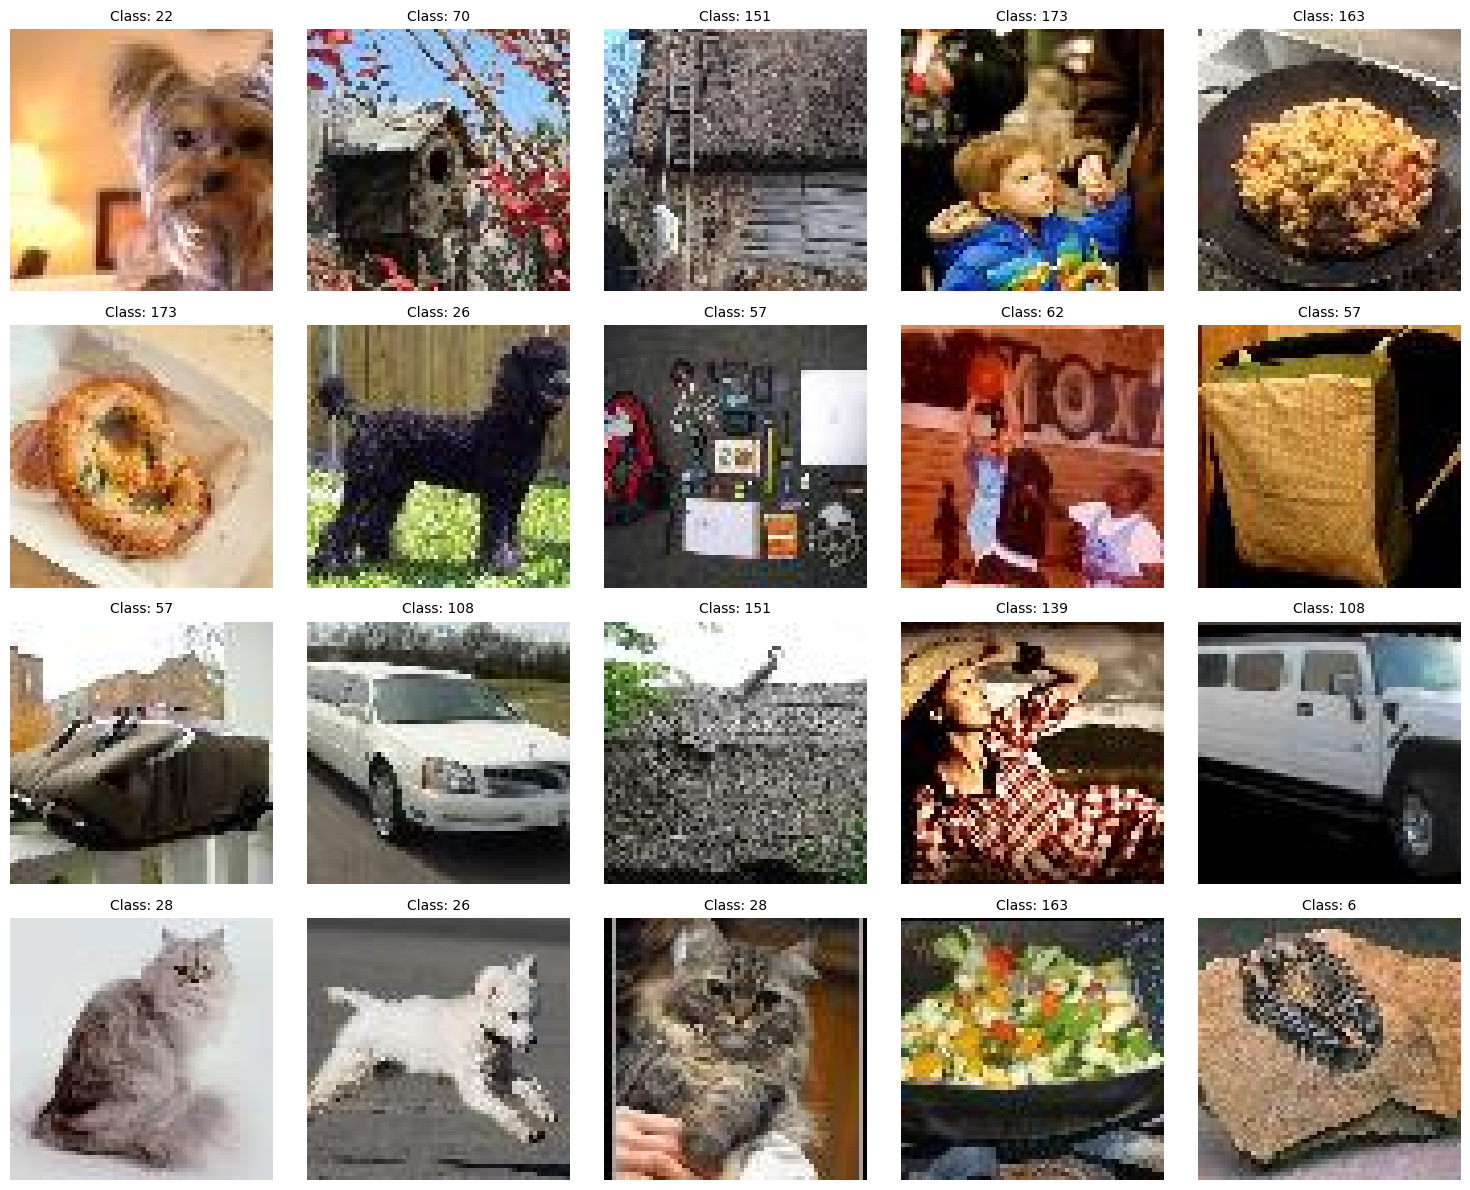

In [ ]:
# Visualize sample images
def visualize_samples(images, labels, num_samples=20):
    if images.max() > 1.0:
        vis_images = images.astype(np.float32) / 255.0
    else:
        vis_images = images

    if vis_images.ndim == 4 and vis_images.shape[1] == 3:
        vis_images = np.transpose(vis_images, (0, 2, 3, 1))

    num_samples = min(num_samples, len(images))
    indices = np.random.choice(len(images), num_samples, replace=False)

    cols = 5
    rows = (num_samples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
    axes = axes.flatten() if num_samples > 1 else [axes]

    for idx, ax in enumerate(axes):
        if idx < num_samples:
            img_idx = indices[idx]
            ax.imshow(vis_images[img_idx])
            ax.set_title(f'Class: {labels[img_idx]}', fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training samples
if 'train_imgs' in locals() and train_imgs is not None:
    print("Sample training images:")
    visualize_samples(train_imgs, train_lbls, num_samples=20)

## 5. Model Architecture

In [ ]:
class CustomCNN(nn.Module):
    """
    Custom CNN Architecture for Tiny ImageNet Classification

    Architecture:
    - 5 Convolutional Blocks (Conv2D -> BatchNorm -> ReLU -> MaxPool)
    - Dropout for regularization
    - 2 Fully Connected layers
    - Output layer with 15 classes
    """

    def __init__(self, num_classes=15, dropout_rate=0.5):
        super(CustomCNN, self).__init__()

        # Block 1: 64x64x3 -> 32x32x64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2: 32x32x64 -> 16x16x128
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3: 16x16x128 -> 8x8x256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 4: 8x8x256 -> 4x4x512
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 5: 4x4x512 -> 2x2x512
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()

        # Fully connected layers: 2x2x512 = 2048
        self.fc1 = nn.Linear(2048, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(1024, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout(dropout_rate / 2)

        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Conv blocks
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.pool5(self.relu5(self.bn5(self.conv5(x))))

        # FC layers
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.dropout2(self.relu6(self.bn6(self.fc1(x))))
        x = self.dropout3(self.relu7(self.bn7(self.fc2(x))))
        x = self.fc3(x)

        return x

# Create model instance
model = CustomCNN(num_classes=15, dropout_rate=0.5)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✓ Model created successfully")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

✓ Model created successfully
Total parameters: 6,547,471
Trainable parameters: 6,547,471


## 6. Training Setup

In [ ]:
class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve"""

    def __init__(self, patience=10, min_delta=0.0001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
        self.best_epoch = 0

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
            self.best_epoch = epoch
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if self.verbose:
                print(f'Validation loss improved from {self.best_loss:.6f} to {val_loss:.6f}')
            self.best_loss = val_loss
            self.best_model_state = model.state_dict().copy()
            self.best_epoch = epoch
            self.counter = 0

print("✓ Early stopping class defined")

✓ Early stopping class defined


In [ ]:
# Hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
DROPOUT_RATE = 0.5
PATIENCE = 15
NUM_CLASSES = 15

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# No augmentation for validation
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Hyperparameters and transforms configured")

Using device: cuda
✓ Hyperparameters and transforms configured


## 7. Load Data

In [ ]:
# Load datasets
print("Loading datasets...")
print("="*60)

train_dataset = TinyImageNetDataset(TRAIN_PICKLE, transform=train_transform)
val_dataset = TinyImageNetDataset(VAL_PICKLE, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print("✓ Data loaded successfully")

Loading datasets...
Loading data from train-70_.pkl...
Loaded 5775 images with shape (5775, 64, 64, 3)
Labels shape: (5775,), Unique classes (remapped): 15
Loading data from validation-10_.pkl...
Loaded 825 images with shape (825, 64, 64, 3)
Labels shape: (825,), Unique classes (remapped): 15

Train batches: 91
Validation batches: 13
✓ Data loaded successfully


## 8. Train Model

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc='Training', leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

print("✓ Training functions defined")

✓ Training functions defined


In [ ]:
model = CustomCNN(num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7
)

early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("✓ Training setup complete")
print(f"Starting training for up to {NUM_EPOCHS} epochs...")
print("="*60)

✓ Training setup complete
Starting training for up to 100 epochs...


In [ ]:
# Training loop
for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 60)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    print(f'Learning Rate: {current_lr:.6f}')

    # Early stopping
    early_stopping(val_loss, model, epoch)

    if early_stopping.early_stop:
        print(f'\n🛑 Early stopping triggered at epoch {epoch+1}')
        print(f'Best model was at epoch {early_stopping.best_epoch+1}')
        break

# Load best model
print(f'\nLoading best model from epoch {early_stopping.best_epoch+1}')
model.load_state_dict(early_stopping.best_model_state)

print("\n" + "="*60)
print("✓ Training complete!")
print(f"Best Validation Accuracy: {max(val_accs):.4f}")
print("="*60)


Epoch 1/100
------------------------------------------------------------


Train Loss: 2.4271 | Train Acc: 0.2005
Val Loss: 2.3434 | Val Acc: 0.2242
Learning Rate: 0.001000

Epoch 2/100
------------------------------------------------------------


Train Loss: 2.0984 | Train Acc: 0.3153
Val Loss: 1.9085 | Val Acc: 0.3855
Learning Rate: 0.001000
Validation loss improved from 2.343415 to 1.908481

Epoch 3/100
------------------------------------------------------------


Train Loss: 1.9065 | Train Acc: 0.3763
Val Loss: 1.6817 | Val Acc: 0.4267
Learning Rate: 0.001000
Validation loss improved from 1.908481 to 1.681709

Epoch 4/100
------------------------------------------------------------


Train Loss: 1.7866 | Train Acc: 0.4197
Val Loss: 1.8862 | Val Acc: 0.4121
Learning Rate: 0.001000
EarlyStopping counter: 1/15

Epoch 5/100
------------------------------------------------------------


Train Loss: 1.7092 | Train Acc: 0.4440
Val Loss: 1.8725 | Val Acc: 0.4097
Learning Rate: 0.001000
EarlyStopping counter: 2/15

Epoch 6/100
------------------------------------------------------------


Train Loss: 1.6253 | Train Acc: 0.4750
Val Loss: 1.6794 | Val Acc: 0.4400
Learning Rate: 0.001000
Validation loss improved from 1.681709 to 1.679379

Epoch 7/100
------------------------------------------------------------


Train Loss: 1.5641 | Train Acc: 0.4883
Val Loss: 1.5463 | Val Acc: 0.5091
Learning Rate: 0.001000
Validation loss improved from 1.679379 to 1.546299

Epoch 8/100
------------------------------------------------------------


Train Loss: 1.5098 | Train Acc: 0.5094
Val Loss: 1.6453 | Val Acc: 0.4836
Learning Rate: 0.001000
EarlyStopping counter: 1/15

Epoch 9/100
------------------------------------------------------------


Train Loss: 1.4587 | Train Acc: 0.5274
Val Loss: 1.4850 | Val Acc: 0.5224
Learning Rate: 0.001000
Validation loss improved from 1.546299 to 1.485024

Epoch 10/100
------------------------------------------------------------


Train Loss: 1.3936 | Train Acc: 0.5439
Val Loss: 1.3764 | Val Acc: 0.5648
Learning Rate: 0.001000
Validation loss improved from 1.485024 to 1.376421

Epoch 11/100
------------------------------------------------------------


Train Loss: 1.3414 | Train Acc: 0.5690
Val Loss: 1.4065 | Val Acc: 0.5673
Learning Rate: 0.001000
EarlyStopping counter: 1/15

Epoch 12/100
------------------------------------------------------------


Train Loss: 1.3268 | Train Acc: 0.5726
Val Loss: 1.3860 | Val Acc: 0.5855
Learning Rate: 0.001000
EarlyStopping counter: 2/15

Epoch 13/100
------------------------------------------------------------


Train Loss: 1.2715 | Train Acc: 0.5790
Val Loss: 1.3743 | Val Acc: 0.5794
Learning Rate: 0.001000
Validation loss improved from 1.376421 to 1.374266

Epoch 14/100
------------------------------------------------------------


Train Loss: 1.2193 | Train Acc: 0.6024
Val Loss: 1.2878 | Val Acc: 0.5891
Learning Rate: 0.001000
Validation loss improved from 1.374266 to 1.287774

Epoch 15/100
------------------------------------------------------------


Train Loss: 1.1931 | Train Acc: 0.6189
Val Loss: 1.6185 | Val Acc: 0.4994
Learning Rate: 0.001000
EarlyStopping counter: 1/15

Epoch 16/100
------------------------------------------------------------


Train Loss: 1.1510 | Train Acc: 0.6274
Val Loss: 1.3815 | Val Acc: 0.5794
Learning Rate: 0.001000
EarlyStopping counter: 2/15

Epoch 17/100
------------------------------------------------------------


Train Loss: 1.1062 | Train Acc: 0.6455
Val Loss: 1.2969 | Val Acc: 0.5891
Learning Rate: 0.001000
EarlyStopping counter: 3/15

Epoch 18/100
------------------------------------------------------------


Train Loss: 1.1001 | Train Acc: 0.6448
Val Loss: 1.5606 | Val Acc: 0.5370
Learning Rate: 0.001000
EarlyStopping counter: 4/15

Epoch 19/100
------------------------------------------------------------


Train Loss: 1.0474 | Train Acc: 0.6630
Val Loss: 1.0453 | Val Acc: 0.6861
Learning Rate: 0.001000
Validation loss improved from 1.287774 to 1.045345

Epoch 20/100
------------------------------------------------------------


Train Loss: 1.0200 | Train Acc: 0.6736
Val Loss: 1.3084 | Val Acc: 0.6024
Learning Rate: 0.001000
EarlyStopping counter: 1/15

Epoch 21/100
------------------------------------------------------------


Train Loss: 0.9838 | Train Acc: 0.6816
Val Loss: 1.2650 | Val Acc: 0.6315
Learning Rate: 0.001000
EarlyStopping counter: 2/15

Epoch 22/100
------------------------------------------------------------


Train Loss: 0.9955 | Train Acc: 0.6755
Val Loss: 1.1700 | Val Acc: 0.6461
Learning Rate: 0.001000
EarlyStopping counter: 3/15

Epoch 23/100
------------------------------------------------------------


Train Loss: 0.9523 | Train Acc: 0.6894
Val Loss: 1.2009 | Val Acc: 0.6327
Learning Rate: 0.001000
EarlyStopping counter: 4/15

Epoch 24/100
------------------------------------------------------------


Train Loss: 0.9157 | Train Acc: 0.6989
Val Loss: 1.1668 | Val Acc: 0.6364
Learning Rate: 0.001000
EarlyStopping counter: 5/15

Epoch 25/100
------------------------------------------------------------


Train Loss: 0.8954 | Train Acc: 0.7145
Val Loss: 1.3388 | Val Acc: 0.6303
Learning Rate: 0.000500
EarlyStopping counter: 6/15

Epoch 26/100
------------------------------------------------------------


Train Loss: 0.7816 | Train Acc: 0.7415
Val Loss: 0.9279 | Val Acc: 0.7164
Learning Rate: 0.000500
Validation loss improved from 1.045345 to 0.927860

Epoch 27/100
------------------------------------------------------------


Train Loss: 0.7244 | Train Acc: 0.7664
Val Loss: 0.9841 | Val Acc: 0.7042
Learning Rate: 0.000500
EarlyStopping counter: 1/15

Epoch 28/100
------------------------------------------------------------


Train Loss: 0.7072 | Train Acc: 0.7765
Val Loss: 1.0693 | Val Acc: 0.6800
Learning Rate: 0.000500
EarlyStopping counter: 2/15

Epoch 29/100
------------------------------------------------------------


Train Loss: 0.6886 | Train Acc: 0.7789
Val Loss: 0.9862 | Val Acc: 0.7042
Learning Rate: 0.000500
EarlyStopping counter: 3/15

Epoch 30/100
------------------------------------------------------------


Train Loss: 0.6495 | Train Acc: 0.7842
Val Loss: 0.9787 | Val Acc: 0.7018
Learning Rate: 0.000500
EarlyStopping counter: 4/15

Epoch 31/100
------------------------------------------------------------


Train Loss: 0.6425 | Train Acc: 0.7906
Val Loss: 1.0893 | Val Acc: 0.6909
Learning Rate: 0.000500
EarlyStopping counter: 5/15

Epoch 32/100
------------------------------------------------------------


Train Loss: 0.6089 | Train Acc: 0.8050
Val Loss: 1.0394 | Val Acc: 0.6970
Learning Rate: 0.000250
EarlyStopping counter: 6/15

Epoch 33/100
------------------------------------------------------------


Train Loss: 0.5535 | Train Acc: 0.8223
Val Loss: 0.8757 | Val Acc: 0.7527
Learning Rate: 0.000250
Validation loss improved from 0.927860 to 0.875663

Epoch 34/100
------------------------------------------------------------


Train Loss: 0.5156 | Train Acc: 0.8341
Val Loss: 0.9480 | Val Acc: 0.7333
Learning Rate: 0.000250
EarlyStopping counter: 1/15

Epoch 35/100
------------------------------------------------------------


Train Loss: 0.4982 | Train Acc: 0.8364
Val Loss: 0.9251 | Val Acc: 0.7370
Learning Rate: 0.000250
EarlyStopping counter: 2/15

Epoch 36/100
------------------------------------------------------------


Train Loss: 0.4777 | Train Acc: 0.8435
Val Loss: 0.9522 | Val Acc: 0.7309
Learning Rate: 0.000250
EarlyStopping counter: 3/15

Epoch 37/100
------------------------------------------------------------


Train Loss: 0.4767 | Train Acc: 0.8421
Val Loss: 0.9457 | Val Acc: 0.7285
Learning Rate: 0.000250
EarlyStopping counter: 4/15

Epoch 38/100
------------------------------------------------------------


Train Loss: 0.4652 | Train Acc: 0.8481
Val Loss: 0.9674 | Val Acc: 0.7261
Learning Rate: 0.000250
EarlyStopping counter: 5/15

Epoch 39/100
------------------------------------------------------------


Train Loss: 0.4511 | Train Acc: 0.8530
Val Loss: 0.9151 | Val Acc: 0.7418
Learning Rate: 0.000125
EarlyStopping counter: 6/15

Epoch 40/100
------------------------------------------------------------


Train Loss: 0.4210 | Train Acc: 0.8625
Val Loss: 0.9045 | Val Acc: 0.7539
Learning Rate: 0.000125
EarlyStopping counter: 7/15

Epoch 41/100
------------------------------------------------------------


Train Loss: 0.3872 | Train Acc: 0.8701
Val Loss: 0.9404 | Val Acc: 0.7503
Learning Rate: 0.000125
EarlyStopping counter: 8/15

Epoch 42/100
------------------------------------------------------------


Train Loss: 0.3729 | Train Acc: 0.8803
Val Loss: 0.9091 | Val Acc: 0.7467
Learning Rate: 0.000125
EarlyStopping counter: 9/15

Epoch 43/100
------------------------------------------------------------


Train Loss: 0.3540 | Train Acc: 0.8838
Val Loss: 0.9149 | Val Acc: 0.7467
Learning Rate: 0.000125
EarlyStopping counter: 10/15

Epoch 44/100
------------------------------------------------------------


Train Loss: 0.3569 | Train Acc: 0.8790
Val Loss: 0.8998 | Val Acc: 0.7588
Learning Rate: 0.000125
EarlyStopping counter: 11/15

Epoch 45/100
------------------------------------------------------------


Train Loss: 0.3443 | Train Acc: 0.8857
Val Loss: 0.9080 | Val Acc: 0.7588
Learning Rate: 0.000063
EarlyStopping counter: 12/15

Epoch 46/100
------------------------------------------------------------


Train Loss: 0.3454 | Train Acc: 0.8880
Val Loss: 0.9112 | Val Acc: 0.7612
Learning Rate: 0.000063
EarlyStopping counter: 13/15

Epoch 47/100
------------------------------------------------------------


Train Loss: 0.3152 | Train Acc: 0.8994
Val Loss: 0.8906 | Val Acc: 0.7661
Learning Rate: 0.000063
EarlyStopping counter: 14/15

Epoch 48/100
------------------------------------------------------------


Train Loss: 0.3172 | Train Acc: 0.8984
Val Loss: 0.8990 | Val Acc: 0.7624
Learning Rate: 0.000063
EarlyStopping counter: 15/15

🛑 Early stopping triggered at epoch 48
Best model was at epoch 33

Loading best model from epoch 33

✓ Training complete!
Best Validation Accuracy: 0.7661


## 9. Save Model

In [ ]:
# Save model
MODEL_SAVE_PATH = 'model.pth'

torch.save({
    'epoch': early_stopping.best_epoch,
    'model_state_dict': model.state_dict(),
    'best_val_loss': early_stopping.best_loss,
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs,
}, MODEL_SAVE_PATH)

print(f"✓ Model saved to {MODEL_SAVE_PATH}")
print(f"File size: {os.path.getsize(MODEL_SAVE_PATH) / (1024*1024):.2f} MB")
print("\n⬇️ Download this file for submission!")

✓ Model saved to model.pth
File size: 25.01 MB

⬇️ Download this file for submission!


## 10. Visualize Results

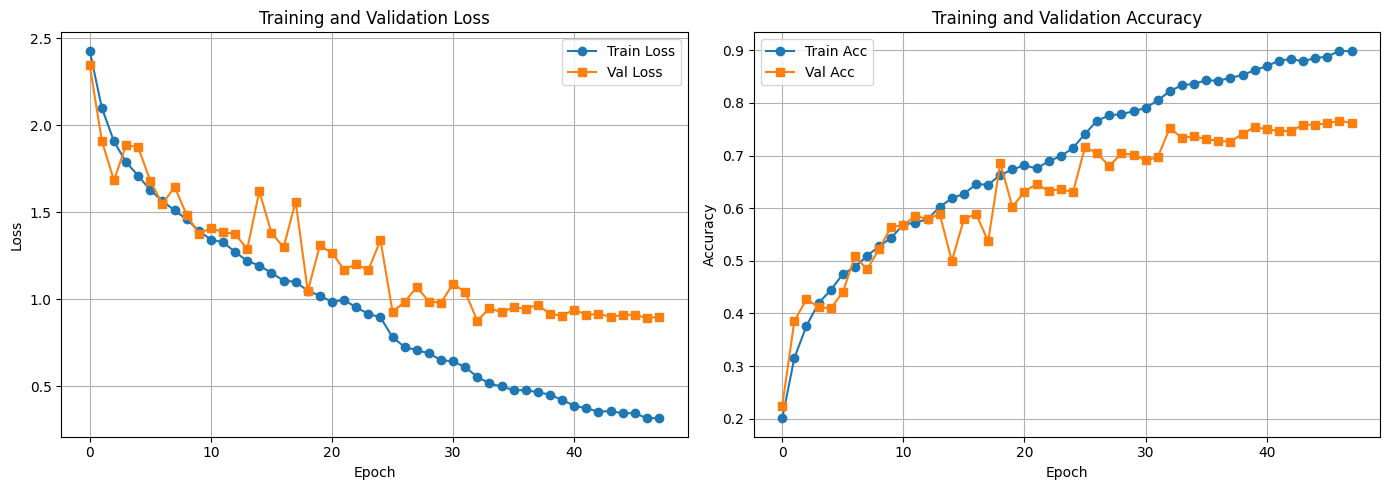

✓ Training history plotted


In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', marker='o')
ax2.plot(val_accs, label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plotted")

In [ ]:
# Final evaluation on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Final Evaluation'):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

final_acc = accuracy_score(all_labels, all_preds)
print(f"\n{'='*60}")
print(f"Final Validation Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")
print(f"{'='*60}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

Final Evaluation: 100%|██████████| 13/13 [00:00<00:00, 30.81it/s]


Final Validation Accuracy: 0.7624 (76.24%)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83        55
           1       0.74      0.71      0.72        55
           2       0.67      0.58      0.62        55
           3       0.75      0.78      0.77        55
           4       0.83      0.82      0.83        55
           5       0.75      0.75      0.75        55
           6       0.87      0.85      0.86        55
           7       0.71      0.73      0.72        55
           8       0.82      0.91      0.86        55
           9       0.66      0.73      0.69        55
          10       0.78      0.73      0.75        55
          11       0.76      0.69      0.72        55
          12       0.70      0.82      0.76        55
          13       0.81      0.80      0.81        55
          14       0.74      0.73      0.73        55

    accuracy                           0.76       825
   macro avg

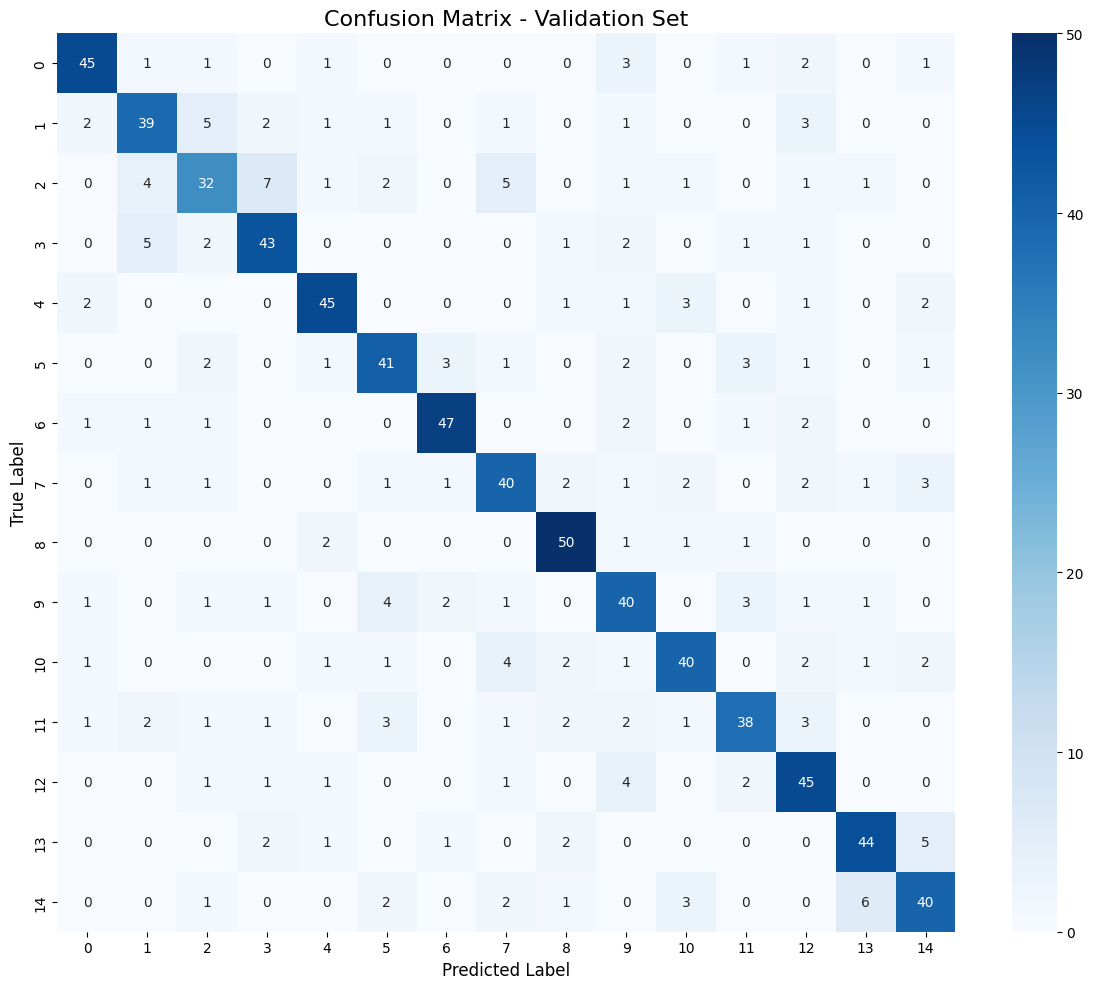

✓ Confusion matrix generated


In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Validation Set', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

print("✓ Confusion matrix generated")

## 11. Download Files

Download these files for submission:
1. `model.pth` - Trained model weights
2. `submission_model.ipynb` - Model and predict functions (see separate notebook)

In [ ]:
# List files to download
from google.colab import files

print("Download model.pth:")
files.download('model.pth')

print("\n✓ Downloaded! Use this with submission_model.ipynb for your submission.")

## Summary

**Training Complete!**

Next steps:
1. ✅ Download `model.pth`
2. ✅ Use `submission_model.ipynb` (separate notebook) for submission
3. ✅ Create `GroupX_Assignment.zip` with:
   - `submission_model.ipynb`
   - `model.pth`
4. ✅ Submit on your course platform

Good luck! 🚀